## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [91]:
import nest_asyncio
nest_asyncio.apply()

In [92]:
import configparser
import json

from telethon.sync import TelegramClient
from telethon import connection

# для корректного переноса времени сообщений в json
from datetime import date, datetime

# классы для работы с каналами
from telethon.tl.functions.channels import GetParticipantsRequest
from telethon.tl.types import ChannelParticipantsSearch

# класс для работы с сообщениями
from telethon.tl.functions.messages import GetHistoryRequest

# Считываем учетные данные
config = configparser.ConfigParser()
config.read("config.ini")

# Присваиваем значения внутренним переменным
api_id   = config['Telegram']['api_id']
api_hash = config['Telegram']['api_hash']
username = config['Telegram']['username']

client = TelegramClient(username, api_id, api_hash)

client.start()


async def dump_all_participants(channel):
	"""Записывает json-файл с информацией о всех участниках канала/чата"""
	offset_user = 0    # номер участника, с которого начинается считывание
	limit_user = 100   # максимальное число записей, передаваемых за один раз

	all_participants = []   # список всех участников канала
	filter_user = ChannelParticipantsSearch('')

	while True:
		participants = await client(GetParticipantsRequest(channel,
			filter_user, offset_user, limit_user, hash=0))
		if not participants.users:
			break
		all_participants.extend(participants.users)
		offset_user += len(participants.users)

	all_users_details = []   # список словарей с интересующими параметрами участников канала

	for participant in all_participants:
		all_users_details.append({"id": participant.id,
			"first_name": participant.first_name,
			"last_name": participant.last_name,
			"user": participant.username,
			"phone": participant.phone,
			"is_bot": participant.bot})

	with open('channel_users.json', 'w', encoding='utf8') as outfile:
		json.dump(all_users_details, outfile, ensure_ascii=False)


async def dump_all_messages(channel):
	"""Записывает json-файл с информацией о всех сообщениях канала/чата"""
	offset_msg = 0    # номер записи, с которой начинается считывание
	limit_msg = 100   # максимальное число записей, передаваемых за один раз

	all_messages = []   # список всех сообщений
	total_messages = 0
	total_count_limit = 0  # поменяйте это значение, если вам нужны не все сообщения

	class DateTimeEncoder(json.JSONEncoder):
		'''Класс для сериализации записи дат в JSON'''
		def default(self, o):
			if isinstance(o, datetime):
				return o.isoformat()
			if isinstance(o, bytes):
				return list(o)
			return json.JSONEncoder.default(self, o)

	while True:
		history = await client(GetHistoryRequest(
			peer=channel,
			offset_id=offset_msg,
			offset_date=None, add_offset=0,
			limit=limit_msg, max_id=0, min_id=0,
			hash=0))
		if not history.messages:
			break
		messages = history.messages
		for message in messages:
			all_messages.append(message.to_dict())
		offset_msg = messages[len(messages) - 1].id
		total_messages = len(all_messages)
		if total_count_limit != 0 and total_messages >= total_count_limit:
			break

	with open('channel_messages.json', 'w', encoding='utf8') as outfile:
		 json.dump(all_messages, outfile, ensure_ascii=False, cls=DateTimeEncoder)


async def main():
	url = input("Введите ссылку на канал или чат: ")
	channel = await client.get_entity(url)
	await dump_all_participants(channel)
	await dump_all_messages(channel)


async with client:
	client.loop.run_until_complete(main())

C:\Users\NATUSA~1\AppData\Local\Temp/ipykernel_15420/1740606310.py:28: RuntimeWarning: coroutine 'AuthMethods._start' was never awaited
  client.start()


ValueError: Cannot find any entity corresponding to ""

In [93]:
import pandas as pd
row_data = pd.read_json('channel_messages.json')

C:\Users\NATUSA~1\AppData\Local\Temp/ipykernel_15420/842120234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date']).dt.date


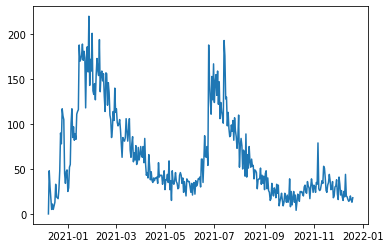

In [94]:
import matplotlib.pyplot as plt

data = row_data[['date', 'message']]
data['date'] = pd.to_datetime(data['date']).dt.date

plot_data = data.groupby(['date']).count()

plt.plot(plot_data)

women  8459
men  5180


C:\Users\NATUSA~1\AppData\Local\Temp/ipykernel_15420/2604743273.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = pd.Series(ages, dtype='int64')


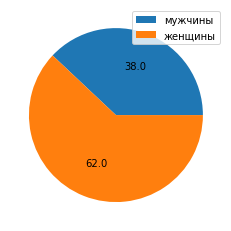

In [95]:

import re
men_count = 0
women_count = 0
ages = []
for i in data['message'].values:
    if pd.isna(i): 
        ages.append(-1)
        continue
    menkeys = re.compile(r'\b[Мм]..?\d\d|\b[Мм]\d\d|\b[Мм]уж.+\d\d\B|[Мм]ужчина').findall(i)
    womkeys = re.compile(r'\b[Жж]..?\d\d|\b[Жж]\d\d|\b[Жж]ен.+\d\d\B|[Жж]енщина').findall(i)
    agekeys = re.compile(r'\b[МмЖж]..?\d\d|\b[МмЖж]\d\d|\b\d\d\sгода?|\b\d\d\sлет|\b[Мм]не \d\d').findall(i)
    if agekeys: 
        s = agekeys[-1][-2:]
        if s.isdigit():
            ages.append(int(s))
        else: 
            s = agekeys[-1][:1]
            if s.isdigit():
                ages.append(int(s))
    else:
        ages.append(-1)
    if not menkeys and womkeys:
        women_count += 1
    if menkeys and not womkeys:
        men_count += 1
data['age'] = pd.Series(ages, dtype='int64')

print('women ', women_count)
print('men ', men_count)
plt.pie([men_count, women_count], autopct='%.1f')
plt.legend(['мужчины', 'женщины'])
plt.show()



array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

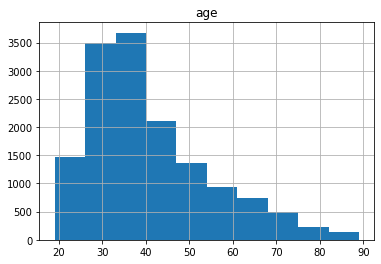

In [96]:
data[(data['age'] > 18) & (data['age'] < 90)].hist()


C:\Users\NATUSA~1\AppData\Local\Temp/ipykernel_15420/4072667515.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['desease'] = pd.Series(isdes, dtype='bool')


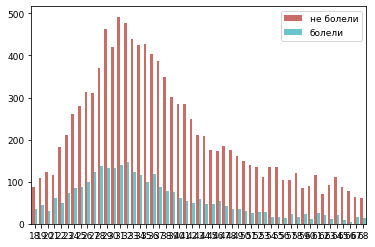

In [153]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

isdes = []
for i in data['message'].values:
    if pd.isna(i): 
        isdes.append(0)
        continue
    deskeys = re.compile(r'\b[Зз]абол|[Чч]увств[\s\S]*плох|ху[жд]').findall(i)
    if deskeys:
        isdes.append(1)
    else:
        isdes.append(0)
data['desease'] = pd.Series(isdes, dtype='bool')
#plt.bar(data['age'], data, color = 'red', label = '2016',zorder = 2)
plot_data = data[(data['desease'] == 1) & (data['age'] > 18) & (data['age'] < 70)].groupby('age').count()
plot_data2 = data[(data['desease'] == 0) & (data['age'] > 18)& (data['age'] < 70)].groupby('age').count()

a = plot_data2['desease'].values.tolist()
b = plot_data['desease'].values.tolist()

sum = dict()
sum['algs_values'] = a + b
sum['iter'] = list(range(18, 17+len(a) + 1)) * 2
res = ['не болели' for _ in range(len(a))]
for i in range(len(a)):
    res.append('болели')
sum['algorithms'] = res 


sns.barplot(data=sum, x='iter', y='algs_values', hue='algorithms', palette="hls")
plt.show()